In [47]:
import csv
import pathlib
import requests
from astropy.io import fits
import astropy.stats
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from lsst.ts import salobj
import SALPY_Electrometer
import datetime

In [2]:
electrometer = salobj.Remote(SALPY_Electrometer,1)


In [80]:
#electrometer.cmd_setMode.set(mode=1)
electrometer.cmd_setIntegrationTime.set(intTime=0.2)
#electrometer.cmd_setDigitalFilter.set(activateFilter=0,activateAvgFilter=False,activateMedFilter=False)


True

In [81]:
#await electrometer.cmd_setDigitalFilter.start(timeout=30)
await electrometer.cmd_setIntegrationTime.start(timeout=30)

CommandIdAck(cmd_id=1553717778, ack.ack=<SALPY_Electrometer.Electrometer_ackcmdC object at 0x7fd5b97ef848>)

In [174]:
#set_electrometer_mode_ack_coro = await electrometer.cmd_setMode.start(timeout=30)
number_of_scans=100
timestamps=[]
for scan in range(number_of_scans):
    print(f"Scan {scan+1} of {number_of_scans}")
    electrometer_data_coro = electrometer.evt_largeFileObjectAvailable.next(flush=True, timeout=45)
    electrometer.cmd_startScanDt.set(scanDuration=30)
    try:
        timestamp = datetime.datetime.now().timestamp()
        timestamps.append(timestamp)
        electrometer_scan_ack = await electrometer.cmd_startScanDt.start(timeout=45)
    except salobj.AckError as ae:
        print(ae)
    with open("laser_stablization.txt","a") as f:
        electrometer_data = await electrometer_data_coro
        electrometer_data.url += ".fits"
        electrometer_fixed_url = electrometer_data.url.replace("https://127.0.0.1","http://10.0.100.133:8000")
        f.write(f"{timestamp},{electrometer_fixed_url}\n")

Scan 1 of 100
Command failed with ack code -301
Scan 2 of 100
Command failed with ack code -301
Scan 3 of 100
Command failed with ack code -301
Scan 4 of 100
Command failed with ack code -301
Scan 5 of 100
Command failed with ack code -301
Scan 6 of 100
Command failed with ack code -301
Scan 7 of 100
Command failed with ack code -301
Scan 8 of 100
Command failed with ack code -301
Scan 9 of 100
Command failed with ack code -301
Scan 10 of 100
Command failed with ack code -301
Scan 11 of 100
Command failed with ack code -301
Scan 12 of 100
Command failed with ack code -301
Scan 13 of 100
Command failed with ack code -301
Scan 14 of 100
Command failed with ack code -301
Scan 15 of 100
Command failed with ack code -301
Scan 16 of 100
Command failed with ack code -301
Scan 17 of 100
Command failed with ack code -301
Scan 18 of 100
Command failed with ack code -301
Scan 19 of 100
Command failed with ack code -301
Scan 20 of 100
Command failed with ack code -301
Scan 21 of 100
Command failed

KeyboardInterrupt: 

In [152]:
with open(f.name,"r") as f2, open("laser_data.txt","w") as ldf:
    for line in f2:
        ldf.write(line)

In [165]:
with open(f"laser_stablization.txt",newline='') as csvfile:
            data_reader = csv.DictReader(csvfile)
            timestamps = []
            fits_file = []
            for row in data_reader:
                electrometer_url = row["fits_file"]
                electrometer_url_name = electrometer_url.split("/")[-1]
                electrometer_fits_request = requests.get(electrometer_url)
                with open(f"/home/saluser/develop/es_stablization_laser_fits_files/electrometer_fits_files/{electrometer_url_name}","wb") as file:
                    file.write(electrometer_fits_request.content)
                timestamp = row["timestamp"]
                timestamps.append(timestamp)
                fits_file.append(electrometer_url_name)

In [168]:
p = pathlib.Path("/home/saluser/develop/es_stablization_laser_fits_files/electrometer_fits_files")
l = fits_file
print("something")
xtime=[]
yintensity=[]
for index,f in enumerate(l):
    print(f)
    hdul = fits.open(p.joinpath(f))
    data=hdul[0].data
    for time in data[0]:
        xtime.append(float(timestamps[index])+time)
    for intensity in data[1]:
        yintensity.append(intensity)

something
1-1553887922.937566.fits
1-1553888009.971827.fits


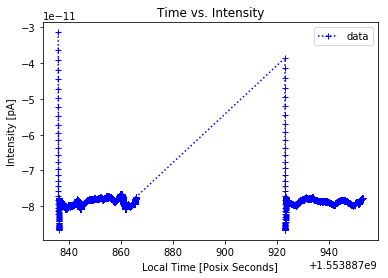

In [169]:
plt.plot(xtime,yintensity,'b+:',label='data')
#plt.ylim([0,2000])
plt.legend()
plt.title('Time vs. Intensity')
plt.ylabel('Intensity [pA]')
plt.xlabel('Local Time [Posix Seconds]')
plt.show()

In [170]:
np.median(yintensity)

-7.8669999999999998e-11

In [89]:
hdul = fits.open(f"{electrometer_url_name}")
print(repr(hdul[0].header))
print(hdul[0].data)
print(hdul[0].data[0])
xtime=[]
for time in hdul[0].data[0]:
    xtime.append(timestamp+time)
yintensity = hdul[0].data[1]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48                                                  
NAXIS2  =                    2                                                  
EXTEND  =                    T                                                  
CLMN1   = 'Time    '           / Time in seconds                                
CLMN2   = 'Intensity'                                                           
HWINFO  = 'KEITHLEY INSTRUMENTS INC.,MODEL 6517B,4114296,A13/700x '             
DERROR  = '-221,-213'          / Device error list                              
ITIME   =                    0 / Start time                                     
ITEMP   =                    0 / Initial temperature                            
ETEMP   =                   

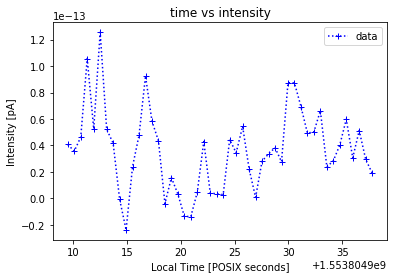

In [90]:
plt.plot(xtime,yintensity,'b+:',label='data')
plt.legend()
plt.title(f"time vs intensity")
plt.xlabel(f"Local Time [POSIX seconds]")
plt.ylabel(f"Intensity [pA]")
plt.show()

In [ ]:
with open(f"laser_coordination.txt",newline='') as csvfile:
            data_reader = csv.DictReader(csvfile)
            timestamps = []
            for row in data_reader:
                electrometer_url = row["electrometer_data_url"]
                electrometer_url += ".fits"
                electrometer_url = electrometer_url.replace("https://127.0.0.1","http://10.0.100.133:8000")
                electrometer_url_name = electrometer_url.split("/")[-1]
                electrometer_fits_request = requests.get(electrometer_url)
                with open(f"/home/saluser/develop/es_stablization_laser_fits_files/electrometer_fits_files/{electrometer_url_name}","wb") as file:
                    file.write(electrometer_fits_request.content)
                timestamp = row["timestamp"]
                timestamps.append(timestamp)

In [ ]:
p = pathlib.Path("/home/saluser/develop/es_stablization_laser_fits_files/electrometer_fits_files")
l = p.glob('*.fits')
print("something")
xtime=[]
yintensity=[]
for index,f in enumerate(l):
    print(f)
    hdul = fits.open(f)
    print(repr(hdul[0].header))
    data=hdul[0].data
    for time in data[0]:
        xtime.append(timestamps[index]+float(time))
    for intensity in data[1]:
        yintensity.append(intensity)

In [ ]:
plt.plot(xtime,yintensity,'b+:',label='data')
#plt.ylim([0,2000])
plt.legend()
plt.title('Time vs. Intensity')
plt.ylabel('Intensity [pA]')
plt.xlabel('Local Time [Posix Seconds]')
plt.show()

In [ ]:
print(data)

In [ ]:
hdul[1].data